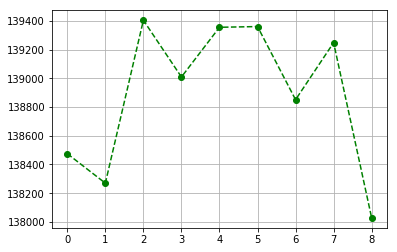

Esto tardó 0.9960572719573975 segundos


In [2]:
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import random
import time
import pandas as pd
import math
import csv
import os

t0=time.time()
###########################################################
###########################################################
# Acordate que en casa los ldata tienen que empezar con Tests/
# En la facultad va directo el nombre del archivo
############################################################
############################################################

def scan(cant,lista):
    i=0
    for x in lista:
        print(x)
        i+=1
        if i>cant:
            break
            
def Tiempo():
    t1=time.time()
    print("Esto tardó {} segundos".format(t1-t0))


def ldata(archive):
        f = open(archive)
        data = []
        for line in f:
            col = line.split("\t")
            col = [x.strip() for x in col]
            data.append(col)
        return data 
    
# Vamos a leer los archivos con esta celda
#--------------------------------------------------------------------------

CarpCheck=[[root,files] for root,dirs,files in os.walk(".")]

# Los primero dos elementos de CarpCheck no les des bola, porque son
# la mismísma carpeta en la que estás y porque el segundo es ipynb checkpoints
# Eso es algo del notebook, no del TP.

Puntos = []

for x in CarpCheck:
    # dada = x[0].split("\\")
    Puntos.append(x[0])

# Con esto tengo los nombres de todas las carpetas que estoy usando
# Fijate que si cambias las carpetas esto cambia

# CarpCheck=[[root,files] for root,dirs,files in os.walk(Puntos[2])]
# Labarcm1 = CarpCheck[0][1]

# Con esto tengo los nombres de todos los archivos en todas las carpetas

#-------------------------------------------------------------------------

Datos = ldata("Red_prueba.txt")
Datos = [int(x) for x in Datos[0][0:len(Datos[0])-1]]

X = []
Y = []

for i in range(max(Datos)+1):
    X.append(i)
    Y.append(Datos.count(i))
    
plt.plot(X,Y,"go--")
plt.grid()
plt.show()

Tiempo()

Esto tardó 0.004000186920166016 segundos
